In [1]:
library('Seurat')
library('dplyr')
library("tidyverse")
library('RColorBrewer')
library('ggplot2')
library('data.table')
library(Matrix.utils)
library(Matrix)
library(tibble)
library(SingleCellExperiment)
library(pheatmap)
library(AUCell)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ───────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘RColorBrewer’ was built under R version 4.0.5”

Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: Matrix


Attaching package: ‘Matrix’


The fol

In [2]:
obj  <- readRDS("/net/bmc-lab5/data/kellis/users/ruiwenfu/scRNA/metastatic_all/takeda_39metastaticSamples_mt10_SCT_RPCAintegrated_cDC021022.rds")

In [3]:
DefaultAssay(obj) <- 'SCT'

In [4]:
exprMatrix <- GetAssayData(object = obj, slot = "counts")

Quantiles for the number of genes detected by cell: 
(Non-detected genes are shuffled at the end of the ranking. Keep it in mind when choosing the threshold for calculating the AUC).



    min      1%      5%     10%     50%    100% 
 220.00  244.59  332.90  414.00  966.00 3695.00 


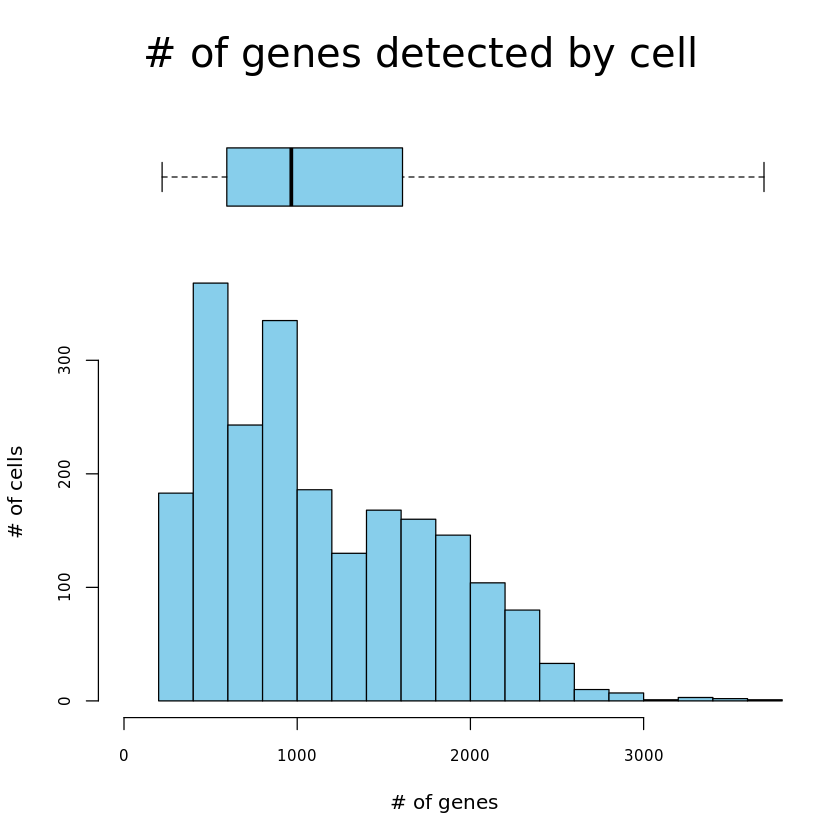

In [5]:
cells_rankings <- AUCell_buildRankings(exprMatrix, plotStats=TRUE)

In [6]:
list.files('/net/bmc-lab5/data/kellis/users/ruiwenfu/011121_RNAseq/analysisReady/GSEA/')

[1] "c2.cp.kegg.v7.4.symbols.gmt"                                                                     
[2] "c5.go.v7.4.symbols.gmt"                                                                          
[3] "c7.immunesigdb.v7.4.symbols.gmt"                                                                 
[4] "h.all.v7.1.symbols.gmt"                                                                          
[5] "PID_NFKAPPAB_CANONICAL_PATHWAY.v7.5.1.gmt"                                                       
[6] "REACTOME_TNF_RECEPTOR_SUPERFAMILY_TNFSF_MEMBERS_MEDIATING_NON_CANONICAL_NF_KB_PATHWAY.v7.5.1.gmt"

In [7]:
# Load the pathways into a named list
path = '/net/bmc-lab5/data/kellis/users/ruiwenfu/011121_RNAseq/analysisReady/GSEA/'

PID_NFKB <- gmtPathways(paste0(path, 'PID_NFKAPPAB_CANONICAL_PATHWAY.v7.5.1.gmt'))
NON_CANON_NFKB <- gmtPathways(paste0(path, 'REACTOME_TNF_RECEPTOR_SUPERFAMILY_TNFSF_MEMBERS_MEDIATING_NON_CANONICAL_NF_KB_PATHWAY.v7.5.1.gmt'))

Warning message in readLines(gmt.file):
“incomplete final line found on '/net/bmc-lab5/data/kellis/users/ruiwenfu/011121_RNAseq/analysisReady/GSEA/PID_NFKAPPAB_CANONICAL_PATHWAY.v7.5.1.gmt'”
Warning message in readLines(gmt.file):
“incomplete final line found on '/net/bmc-lab5/data/kellis/users/ruiwenfu/011121_RNAseq/analysisReady/GSEA/REACTOME_TNF_RECEPTOR_SUPERFAMILY_TNFSF_MEMBERS_MEDIATING_NON_CANONICAL_NF_KB_PATHWAY.v7.5.1.gmt'”


In [8]:
c(PID_NFKB, NON_CANON_NFKB)

$PID_NFKAPPAB_CANONICAL_PATHWAY
 [1] "ATM"      "BCL10"    "BIRC2"    "CHUK"     "CYLD"     "ERC1"    
 [7] "IKBKB"    "IKBKG"    "MALT1"    "NFKB1"    "NFKBIA"   "NOD2"    
[13] "PRKCA"    "RAN"      "RELA"     "RIPK2"    "SSPOP"    "TNF"     
[19] "TNFAIP3"  "TNFRSF1A" "TRAF6"    "UBE2D3"   "XPO1"    

$REACTOME_TNF_RECEPTOR_SUPERFAMILY_TNFSF_MEMBERS_MEDIATING_NON_CANONICAL_NF_KB_PATHWAY
 [1] "BIRC2"     "BIRC3"     "CD40"      "CD40LG"    "LTA"       "LTB"      
 [7] "LTBR"      "MAP3K14"   "TNFRSF11A" "TNFRSF12A" "TNFRSF13C" "TNFSF11"  
[13] "TNFSF12"   "TNFSF13B"  "TNFSF14"   "TRAF2"     "TRAF3"

In [9]:
pathway_AUC <- AUCell_calcAUC(c(PID_NFKB, NON_CANON_NFKB), cells_rankings)

Genes in the gene sets NOT available in the dataset: 
	PID_NFKAPPAB_CANONICAL_PATHWAY: 	1 (4% of 23)



In [10]:
AUC.df <- obj@meta.data[c('Ident', 'uid', 'state')] %>% cbind(t(getAUC(pathway_AUC)))

In [11]:
AUC.df_long <- AUC.df %>% rownames_to_column('cell') %>%
    melt(id.vars = c("cell","Ident", "state", 'uid'), variable.name = "pathway",
         value.name = "AUC")

AUC.df_long$state <- factor(AUC.df_long$state, levels = c('PRE','ON', 'POST'))

Warning message in melt(., id.vars = c("cell", "Ident", "state", "uid"), variable.name = "pathway", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”


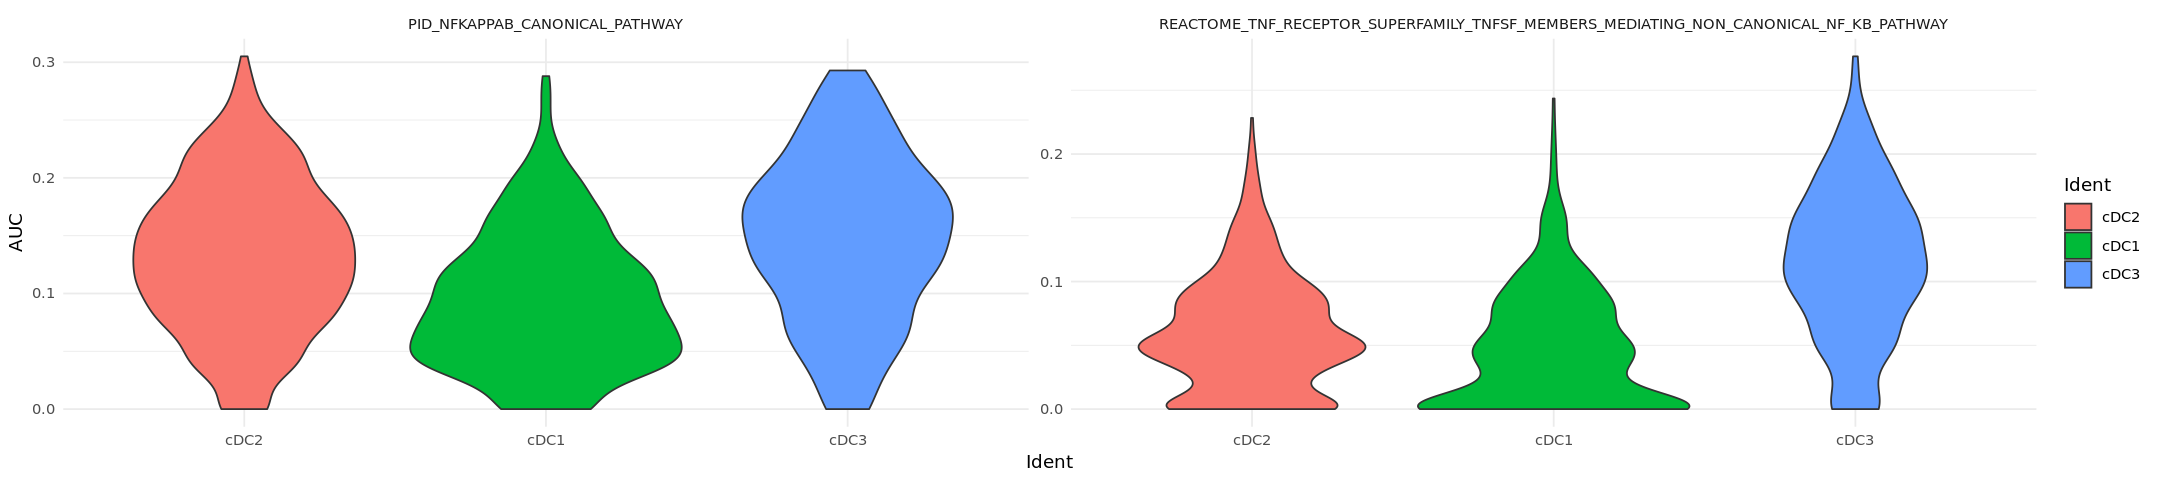

In [12]:
options(repr.plot.width=18, repr.plot.height=4)

AUC.df_long %>%
    ggplot( aes(fill=Ident, y=AUC, x=Ident)) + 
    geom_violin() +
    facet_wrap(~pathway, scale="free")+theme_minimal()


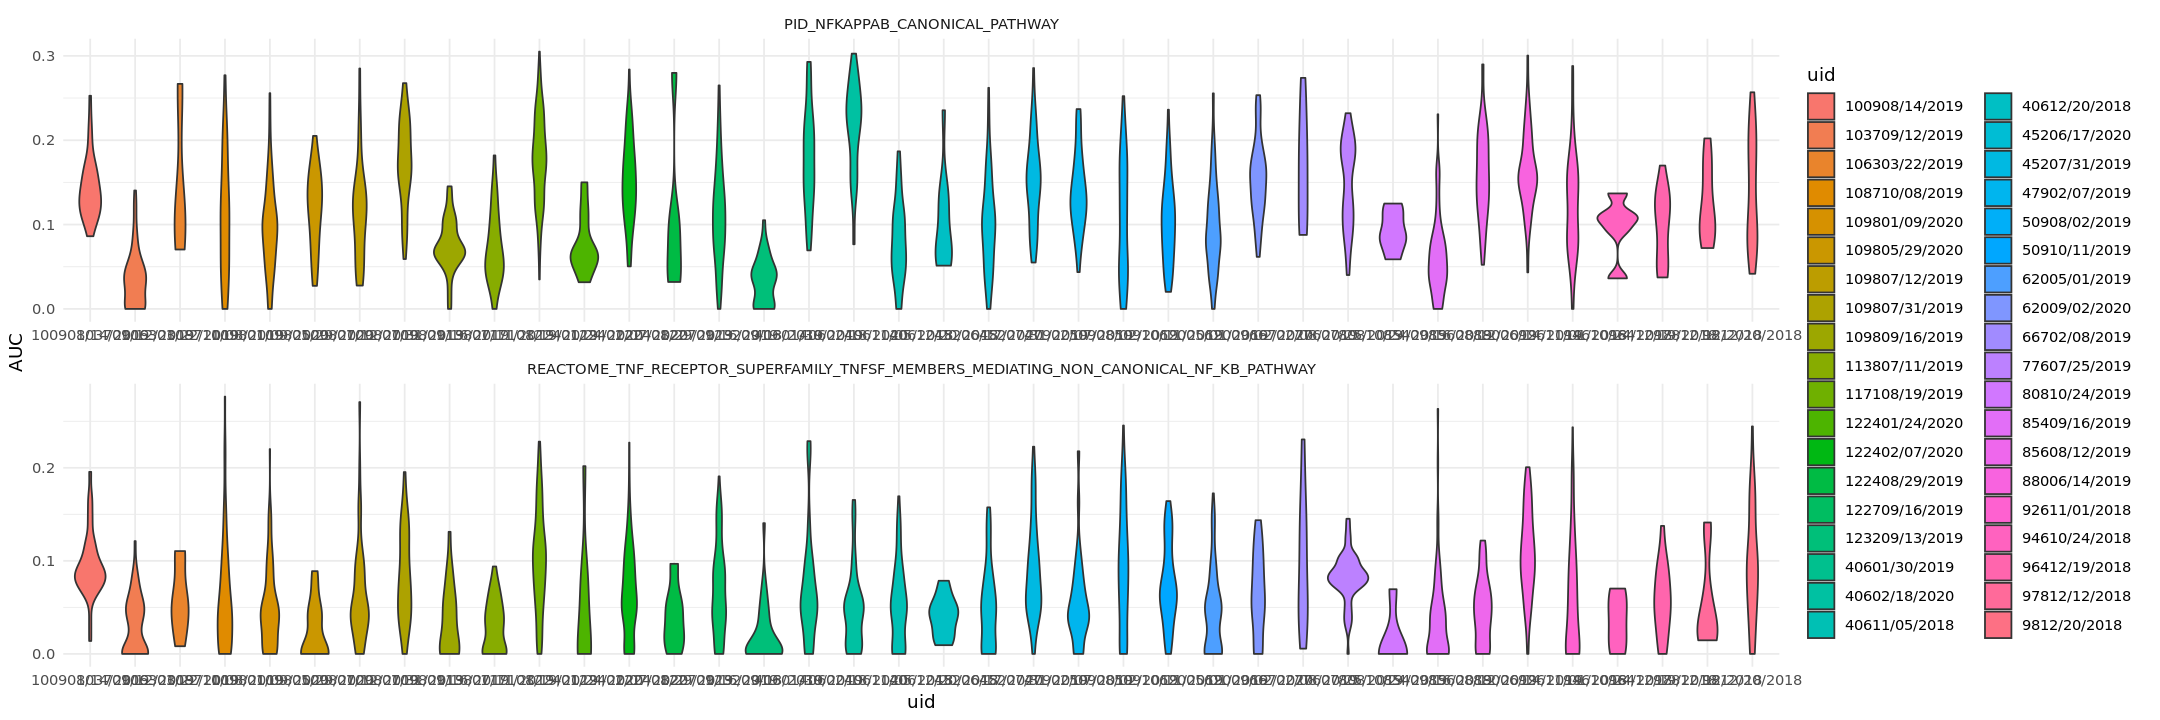

In [13]:
options(repr.plot.width=18, repr.plot.height=6)

AUC.df_long %>%
    ggplot( aes(fill=uid, y=AUC, x=uid)) + 
    geom_violin() +
    facet_wrap(~pathway, scale="free", ncol = 1)+theme_minimal()